In [1]:
# supress tensorflow warnings and info
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import multiprocessing as mp
import time

import numpy as np
import pandas as pd
import tensorflow_text

from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

In [3]:
import tensorflow as tf

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow_hub as hub

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# preprocess untranslated dataset
df_cdp_multi = pd.read_csv('csvs/cdp_clean.csv', sep=',').drop(columns=['Unnamed: 0'])
df_es_multi = pd.read_csv('csvs/es_clean.csv', sep=',').drop(columns=['Unnamed: 0'])
df_joined_multi = pd.concat([df_cdp_multi, df_es_multi], axis=0)[['area', 'title+desc']]

area_energy = (df_joined_multi['area'] == 'energy efficiency / retrofit') | (df_joined_multi['area'] == 'energy efficiency (including public lighting)')
df_joined_multi.loc[area_energy, 'area'] = 'energy effiency'

area_waste = df_joined_multi['area'] == 'waste management (including waste recycling)'
df_joined_multi.loc[area_waste, 'area'] = 'waste management'

min_sample_count = 100
area_count = pd.DataFrame(df_joined_multi.value_counts(subset='area')).rename(columns={0: 'sample_count'})
areas_to_keep = area_count[area_count > min_sample_count].dropna().index.to_list()
area_filter = df_joined_multi['area'].isin(areas_to_keep)
df_clean_multi = df_joined_multi[area_filter]
df_clean_multi

,area,title+desc
0,energy effiency,intensity control of led light points for high...
1,waste management,instalación de planta trituradora de llantas. ...
2,transport,seguimiento y control ambiental a tecnologías ...
3,waste management,fortalecimiento programa de reciclaje inclusiv...
4,waste management,waste to energy project for blantyre city. reh...
...,...,...
482,water management,restauracion de las cuencas de agua. se preten...
483,energy effiency,sustainable tourism development program in iga...
484,water management,caminho das águas. o projeto prevê a a realiza...
486,waste management,implantação do aterro sanitário em forma de co...


In [5]:
param_sets = [
    # model_type, hidden_neurons, epochs
    (True, 'use-multi', 24, (25, 3))
]

In [6]:
# selecting the parameters
multilingual, model_type, hidden_neurons, epochs = param_sets[0]

In [7]:
# x is input, y is output
df_dataset = df_clean_multi
x = df_dataset['title+desc'].to_numpy()
y = df_dataset['area'].to_numpy()

# one hot encode the output
label_binarizer = LabelBinarizer()
y_e = label_binarizer.fit_transform(y)

In [8]:
# split the dataset into train, test and val
x_train, x_valtest, y_train, y_valtest = train_test_split(x, y_e, test_size=0.30, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size=0.5, random_state=42)

In [9]:
# function that implements the model creation, training and deletion
def fit_keras(x_train,
              y_train,
              x_val,
              y_val,
              classes,
              model_type,
              hidden_neurons,
              epochs):
    
    # bring pre-trained model from tf hub as a layer
    if model_type == 'nnlm50':
        hub_layer = hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2', input_shape=[], dtype=tf.string)
    elif model_type == 'nnlm128':
        hub_layer = hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2', input_shape=[], dtype=tf.string)
    elif model_type == 'use':
        hub_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', input_shape=[], dtype=tf.string)
    elif model_type == 'use-multi':
        hub_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3', input_shape=[], dtype=tf.string)

    # create the model with the parameters given
    # model = tf.keras.Sequential()
    # model.add(hub_layer)
    # if hidden_neurons > 0:
    #     model.add(tf.keras.layers.Dropout(0.2))
    #     model.add(tf.keras.layers.Dense(hidden_neurons, activation='relu'))
    # model.add(tf.keras.layers.Dropout(0.2))
    # model.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

    inputs = tf.keras.Input(shape=[], dtype=tf.string)
    x = hub_layer(inputs, training=False)
    if hidden_neurons > 0:
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(hidden_neurons, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(len(classes), activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    # enable tensorboard visualizations
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

    # enable early stopping
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.losses.CategoricalCrossentropy(),
                  metrics=[tf.metrics.CategoricalAccuracy()])

    # finally, fit the model on the data given
    history_tf = model.fit(x_train,
                        y_train,
                        epochs=epochs[0],
                        batch_size=32,
                        validation_data=[x_val, y_val],
                        verbose=1,
                        callbacks=[tensorboard_callback, early_stopping_callback])
    
    # set hub layer to trainable
    hub_layer.trainable = True
    
    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss=tf.losses.CategoricalCrossentropy(),
                  metrics=[tf.metrics.CategoricalAccuracy()])

    # finally, fit the model on the data given
    history_ft = model.fit(x_train,
                        y_train,
                        epochs=epochs[1],
                        batch_size=32,
                        validation_data=[x_val, y_val],
                        verbose=1,
                        callbacks=[tensorboard_callback, early_stopping_callback])

    # return model
    return model, history_tf, history_ft

In [10]:
# train a model
model, history_tf, history_ft = fit_keras(x_train=x_train,
                                          y_train=y_train,
                                          x_val=x_val,
                                          y_val=y_val,
                                          classes=np.unique(y),
                                          model_type=model_type,
                                          hidden_neurons=hidden_neurons,
                                          epochs=epochs)

Epoch 1/25
35/35 [==============================] - 7s 49ms/step - loss: 1.7164 - categorical_accuracy: 0.4103 - val_loss: 1.6019 - val_categorical_accuracy: 0.5812
Epoch 2/25
35/35 [==============================] - 1s 23ms/step - loss: 1.5088 - categorical_accuracy: 0.5943 - val_loss: 1.3883 - val_categorical_accuracy: 0.6752
Epoch 3/25
35/35 [==============================] - 1s 23ms/step - loss: 1.3106 - categorical_accuracy: 0.6502 - val_loss: 1.1970 - val_categorical_accuracy: 0.7350
Epoch 4/25
35/35 [==============================] - 1s 23ms/step - loss: 1.1378 - categorical_accuracy: 0.6813 - val_loss: 1.0512 - val_categorical_accuracy: 0.7479
Epoch 5/25
35/35 [==============================] - 1s 23ms/step - loss: 1.0034 - categorical_accuracy: 0.7070 - val_loss: 0.9483 - val_categorical_accuracy: 0.7479
Epoch 6/25
35/35 [==============================] - 1s 23ms/step - loss: 0.9180 - categorical_accuracy: 0.7060 - val_loss: 0.8742 - val_categorical_accuracy: 0.7607
Epoch 7/25

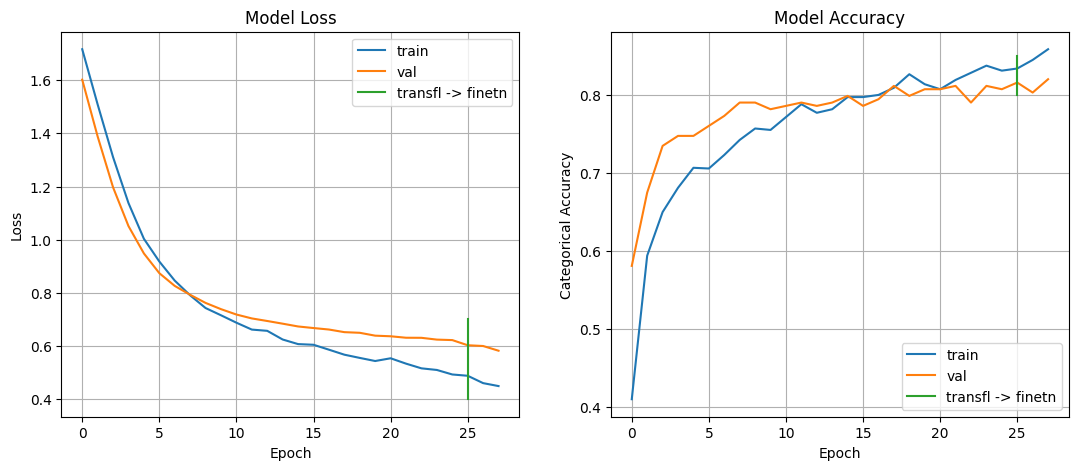

In [19]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(13, 5))

ax_loss.plot(history_tf.history['loss'] + history_ft.history['loss'])
ax_loss.plot(history_tf.history['val_loss'] + history_ft.history['val_loss'])
ax_loss.plot([25, 25], [0.4, 0.7])
ax_loss.set_title('Model Loss')
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Loss')
ax_loss.legend(['train', 'val', 'transfl -> finetn'])
ax_loss.grid()

ax_acc.plot(history_tf.history['categorical_accuracy'] + history_ft.history['categorical_accuracy'])
ax_acc.plot(history_tf.history['val_categorical_accuracy'] + history_ft.history['val_categorical_accuracy'])
ax_acc.plot([25, 25], [0.8, 0.85])
ax_acc.set_title('Model Accuracy')
ax_acc.set_xlabel('Epoch')
ax_acc.set_ylabel('Categorical Accuracy')
ax_acc.legend(['train', 'val', 'transfl -> finetn'])
ax_acc.grid()

In [20]:
# save model
model.save('models/trained_model.h5')

In [20]:
# load model
model = tf.keras.models.load_model('models/trained_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [21]:
# get train accuracy
train_loss, train_acc = model.evaluate(x_train, y_train, batch_size=32)
train_acc

35/35 [==============================] - 1s 15ms/step - loss: 0.3550 - categorical_accuracy: 0.9011


0.901098906993866

In [22]:
# get val accuracy
val_loss, val_acc = model.evaluate(x_val, y_val, batch_size=32)
val_acc

8/8 [==============================] - 0s 14ms/step - loss: 0.5824 - categorical_accuracy: 0.8205


0.8205128312110901

In [23]:
# get test accuracy
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=32)
test_acc

8/8 [==============================] - 0s 14ms/step - loss: 0.5673 - categorical_accuracy: 0.7778


0.7777777910232544

In [24]:
p = model.count_params()
print(f'{int(p/1e6)} M')

68 M


In [25]:
# put accuracy results on a table
df_acc = pd.DataFrame({'train': [train_acc], 'val': [val_acc], 'test': [test_acc]}, index=['acc']).T
df_acc

,acc
train,0.901099
val,0.820513
test,0.777778


In [26]:
# print table
print(df_acc.apply(lambda r: f'{r["acc"]:.4f}', axis=1).to_markdown())

|       |      0 |
|:------|-------:|
| train | 0.9011 |
| val   | 0.8205 |
| test  | 0.7778 |


8/8 [==============================] - 1s 15ms/step


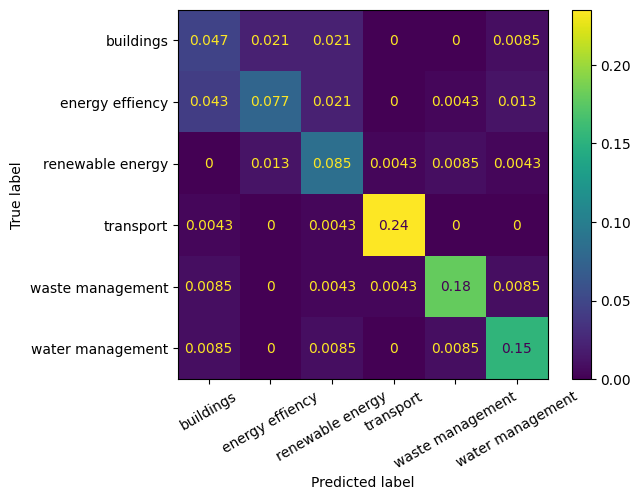

In [27]:
# confusion matrix
y_true = label_binarizer.inverse_transform(y_test)
y_pred = label_binarizer.inverse_transform(model.predict(x_test))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='all', xticks_rotation=30)

In [28]:
label_binarizer.inverse_transform(model.predict(np.array([
    'solar wind farm on the netherlands creating sustainable energy for a small town',
    'sistema de recolhimento de lixo automatizado por caminhões',
    'sistema de tratamento de esgoto'
])))

1/1 [==============================] - 0s 18ms/step


array(['renewable energy', 'waste management', 'water management'],
      dtype='<U16')